In [1]:
import pandas as pd
import itertools
import random
from tqdm import tqdm

# CoinOracle Class

In [2]:
class CoinOracle:
    def __init__(self, n_coins, secret_coin, is_heavier):

        assert secret_coin <= n_coins 

        # Secret attributes
        self.__secret_coin = secret_coin
        self.__is_heavier = is_heavier
        self.__coin_weights = list([5 for _ in range(n_coins+1)])
        self.__coin_weights[secret_coin] = 5.1 if is_heavier else 4.9
        self.__experiment_results = []
        self.__check_guess_count = 0

    def __repr__(self):
        return f"CoinOracle: {self.n_coins} coins and {self.n_tests} tests made"

    def __weight(self,coin_list):
        return sum([self.__coin_weights[i] for i in coin_list])

    # Accessible attributes
    @property
    def n_coins(self):
        return len(self.__coin_weights)-1

    @property
    def n_tests(self):
        return len(self.__experiment_results)

    @property
    def experiment_results(self):
        return self.__experiment_results

    # Key methods
    def is_left_side_heavier(self, left_side, right_side):
        if self.__weight(left_side) >  self.__weight(right_side):
            result = 1
        elif self.__weight(left_side) <  self.__weight(right_side):
            result = -1
        else:
            result = 0
        self.experiment_results.append((left_side,right_side, result))
        return result

    def check_guess(self, secret_coin, is_heavier):
        self.__check_guess_count += 1
        return secret_coin==self.__secret_coin and is_heavier==self.__is_heavier

# Brute Force Solution

In [3]:
def brute_force_solution(temp_oracle):
    for i in range(0,temp_oracle.n_coins):
        temp_oracle.is_left_side_heavier([i+1],[0])
    result = [result for result in temp_oracle.experiment_results if result[2]!=0][0]
    coin = result[0][0]
    is_heavier = result[2]==1
    return (coin, is_heavier)

def marta(temp_oracle):
    coins = list(range(temp_oracle.n_coins + 1))

    while True:
        if len(coins) == 2:
            break

        chunk_size = int(len(coins) / 3)
        chunks = [coins[i * chunk_size:(i + 1) * chunk_size] for i in
                  range((len(coins) + chunk_size - 1) // chunk_size)]

        if temp_oracle.is_left_side_heavier(chunks[0], chunks[1]) == 0:
            coins = [0]
            for i in range(2, len(chunks)):
                coins += chunks[i]
        else:
            coins = chunks[0] + chunks[1]

    return coins[1], not temp_oracle.is_left_side_heavier([coins[0]], [coins[1]]) == 1

# Your solution

The solution is similar to a brute force solution, but it stops when the fake coin is found. Can you improve it?

In [4]:
def your_custom_solution(temp_oracle):
    i=1
    while temp_oracle.is_left_side_heavier([i],[0])==0:
        i+=1
    coin = i
    is_heavier = temp_oracle.experiment_results[-1][2]==1
    return (coin, is_heavier)

# The code below runs games for a given list of solvers

In [5]:
list({brute_force_solution: 2}.values())

[2]

In [6]:
# Runs one game for each size in sizes, using all solvers passed. Filename is used to store the plot in the end as a file.
def run_comparison(sizes, solvers):
    df = pd.DataFrame(
        max(sizes)+1,
        columns=[solver.__name__ for solver in solvers],
        index=sizes
    )
    
    secret_coins = {size: random.choice(range(size))+1 for size in sizes}
    
    n_pairs = len(sizes)*len(solvers)
    for (size, solver) in tqdm(itertools.product(sizes, solvers), total=n_pairs):
        oracle = CoinOracle(
            n_coins = size,
            secret_coin = secret_coins[size],
            is_heavier = random.choice([True,False])
        )
        (guessed_secret_coin, guess_is_heavier) = solver(oracle)
        if oracle.check_guess(guessed_secret_coin, guess_is_heavier):
            df[solver.__name__][size] = oracle.n_tests
    
    return df

In [7]:
sizes = list(range(10,100,5))
solvers = [brute_force_solution, marta]
df = run_comparison(sizes, solvers)
df.T

100%|██████████| 36/36 [00:00<00:00, 1665.67it/s]


,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
brute_force_solution,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
marta,4,6,6,6,6,7,7,6,8,6,6,8,8,7,9,7,8,9


### The plot below shows the number of experiments conducted by your custom solution vs a brute force attack, for multiple sizes. What is the best score you can get? 

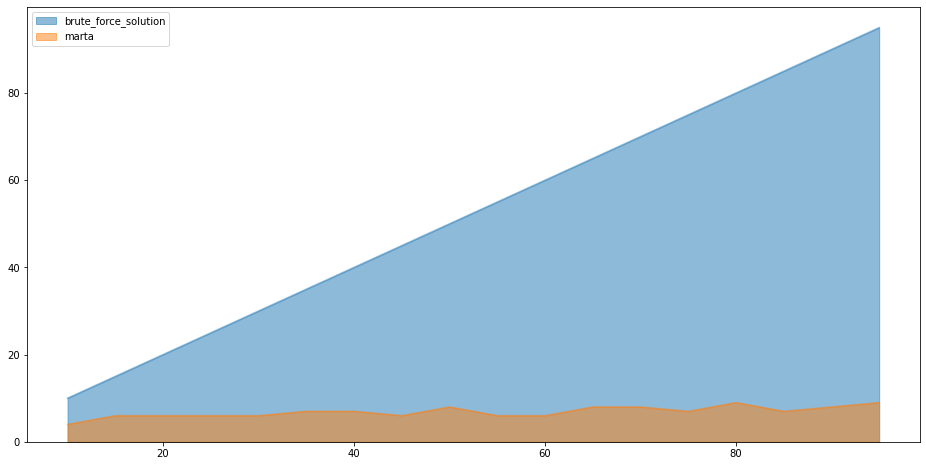

In [8]:
df.plot.area(figsize=(16,8), stacked=False).figure.savefig('results.png')